# Monday, April 21st, 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Conway's Game of Life

Conway's [Game of Life](https://conwaylife.com/wiki/Conway%27s_Game_of_Life) is a cellular automaton created by John Conway in 1970. Similar to the Mayfly model, it is a deterministic process to update the state of a population of cells.

We will use 2D NumPy arrays to represent the population of cells aranged in an $n \times n$ grid.
A value of `1` will signify that a cell is alive while a value of `0` will signify that a cell is dead.

### Starting configuration

Lets begin with an $ n\times n $ array of all 0s with a small three-block column (3$\times$1) of 1s in the middle. Use an integer datatype (`dtype=int`) when defining your array.

**Exercise:**  Write a function `starting_state(n)` that returns the array described above.

In [2]:
def starting_state(n):
    cells = np.zeros((n,n), dtype=int)
    cells[n//2-1:n//2+2, n//2] = 1

    return cells



Let's visualize this configuration with `plt.imshow`:

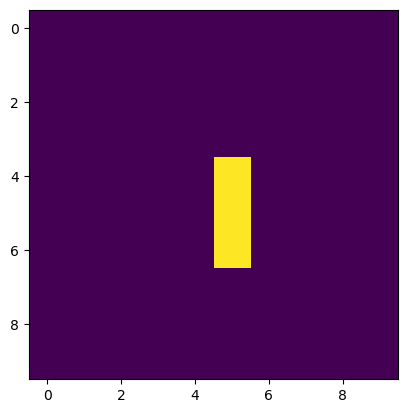

In [3]:
n = 10

cells = starting_state(n)

plt.imshow(cells)



### Rules of Life

We will use the current state of the population to determine the next state.
In the Game of Life, each cell interacts with its eight neighbors (i.e. the horizontally, vertically, or diagonally adjacent cells).

![neighbors](https://jllottes.github.io/_images/epidemic-2.svg)

The rules of the Game of Life can be summarized as follows:

 1. Any live cell with two or three live neighbors survives.
 2. Any dead cell with with three live neighbors becomes a live cell.
 3. All other live cells die in the next generation, and all other dead cells stay dead.

### Counting the number of live neighbors

In order to update our array from one state to the next, we need to be able to count the number of live neighbors of the $(i,j)$th cell for any choice of $i,j$.

**Exercise:** Write a function `count_live_neighbors(cells,i,j)` that counts the number of living neighbors of the $(i,j)$th cell.

 - We handled a similar problem with the [Image Denoising](https://jllottes.github.io/Projects/image_denoising/image_denoising) project.
 - How can we handle cells on the edge of the grid?
 - The `np.sum` function will add all values in an array.
 - We want to exclude (or remove from the sum) the $(i,j)$th cell when counting the number of living neighbors.



For image denoising, we discussed padding our array before constructing `3` by `3` grids centered at each pixel:

In [7]:
def count_live_neighbors(cells,i,j):
    nrows, ncols = cells.shape
    padded_cells = np.zeros((nrows+2, ncols+2), dtype=int)
    padded_cells[1:-1, 1:-1] = cells

    # Recall: The [i,j]th index of cells corresponds to
    # the [i+1, j+1]st index of padded_cells
    
    # We want a 3 by 3 grid centered at the [i,j]th cell of cells
    grid = padded_cells[i:i+3, j:j+3]

    # We can subtract cells[i,j] from the sum
    # to either remove a wrongly counted live neighbor
    # or do nothing if cells[i,j] is not alive
    live_neighbors = np.sum(grid) - cells[i,j]
    
    return live_neighbors

Let's test our function on the starting configuration previously defined:

In [10]:
print(cells)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [12]:
print(count_live_neighbors(cells, 3, 5))
print(count_live_neighbors(cells, 4, 5))
print(count_live_neighbors(cells, 5, 5))
print(count_live_neighbors(cells, 5, 6))

1
1
2
3


### Updating the `cells` population

We can now update the `cells` array according to the rules.  We have to update every entry of the array, so we will need to loop through all the entries.

**Exercise:** Write a function `update_cells(cells)` that takes in a population array `cells`, applies the Rules of Life to update the population, and returns the updated population.

In [13]:
def update_cells(cells):
    new_cells = cells.copy()

    nrows, ncols = cells.shape
    for i in range(nrows):
        for j in range(ncols):
            # Get the number of live neighbors, excluding the cell itself
            live_neighbors = count_live_neighbors(cells, i, j)
            
            # If the is alive...
            if cells[i,j] == 1:
                # and if the cell has exactly 2 or 3 live neighbors...
                if live_neighbors == 2 or live_neighbors == 3:
                    # then the cell lives
                    new_cells[i,j] = 1
                else:
                    # otherwise the cell dies
                    new_cells[i,j] = 0
            # If the cell is not alive...
            else:
                # and if it has exactly 3 live neighbors...
                if live_neighbors == 3:
                    # then the cell becomes alive
                    new_cells[i,j] = 1
                else:
                    # otherwise the cell remains dead
                    new_cells[i,j] = 0
    return new_cells


Text(0.5, 1.0, 'New cells')

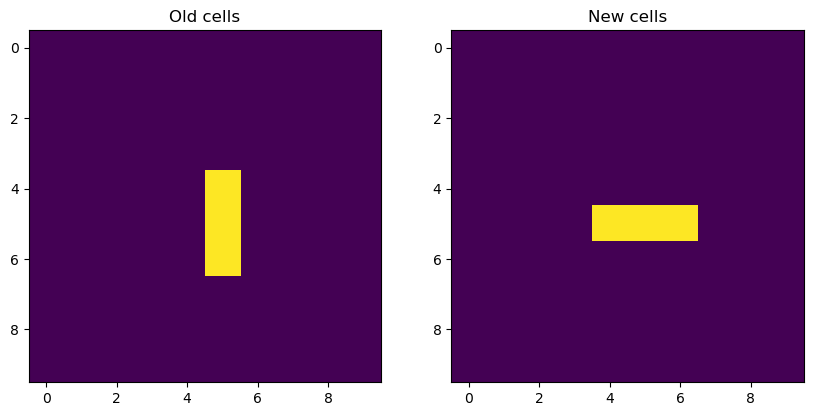

In [15]:
new_cells = update_cells(cells)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(cells)
plt.title('Old cells')

plt.subplot(1,2,2)
plt.imshow(new_cells)
plt.title('New cells')

### Animating the dynamics

The `FuncAnimation` function from `matplotlib.animation` can be used to create animations.
It takes in a figure `fig` and function `animate`. The `animate` function should take in a frame index `i` and perform any desired updates to the figure.

In [16]:
%matplotlib notebook
#%matplotlib qt
from matplotlib.animation import FuncAnimation

**Exercise:** Modify the code below to animate the Game of Life.

Instead of visualizing the array `x`, we want to visualize `cells`. For each frame of animation, we want to update the cells array, i.e. `cells = update_cells(cells)`.

<IPython.core.display.Javascript object>


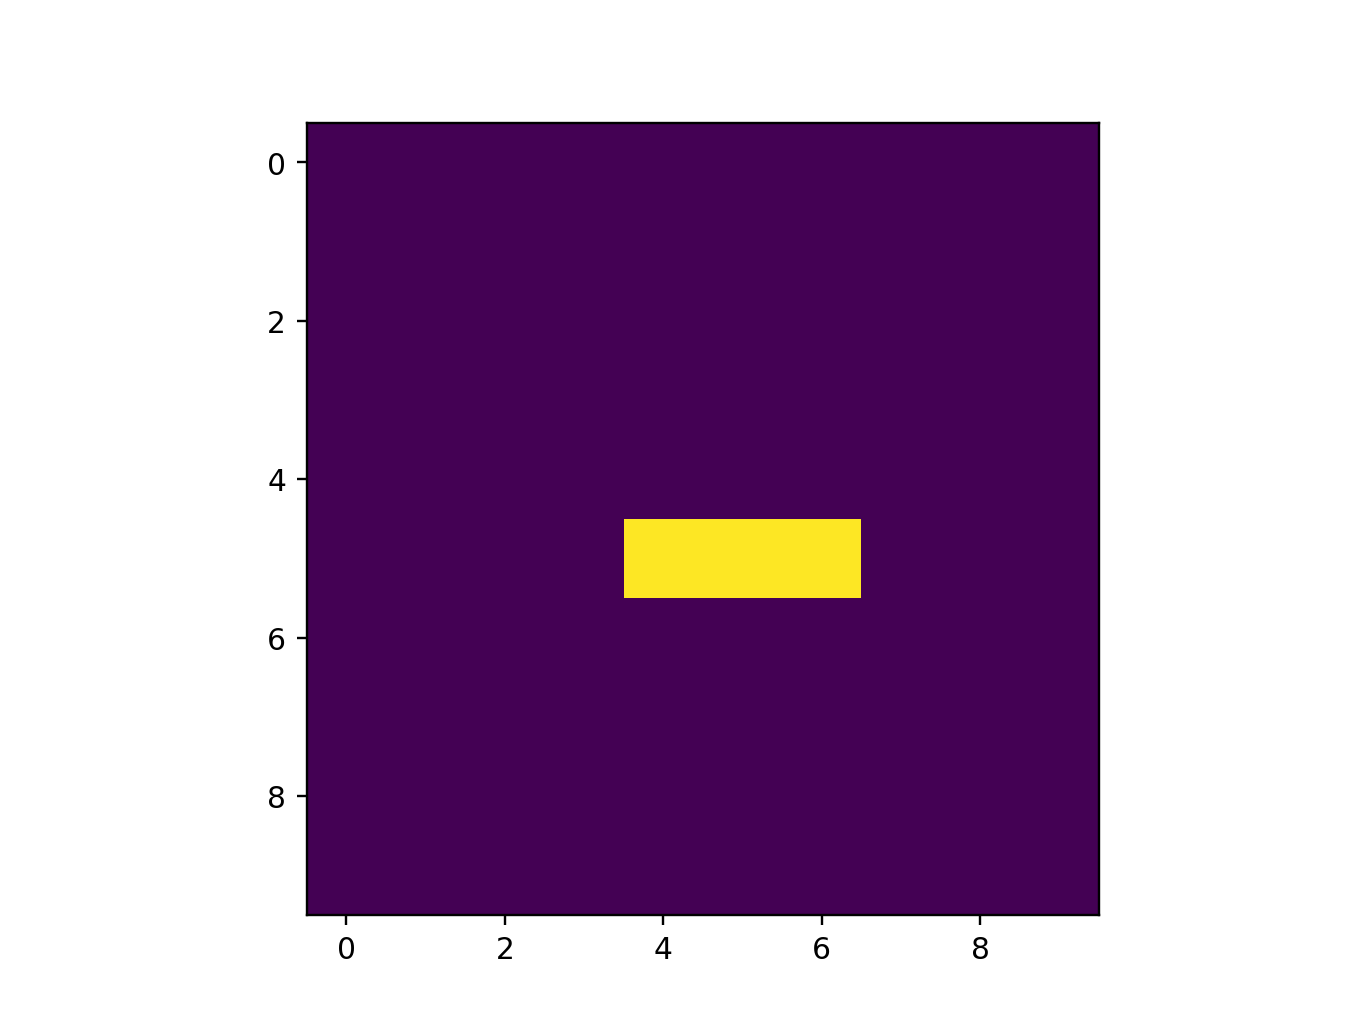

In [19]:
#x = np.zeros((200,200), dtype = int)
n = 10
cells = starting_state(n)

fig = plt.figure()
im = plt.imshow(cells,vmin=0,vmax=1)               # Generate the initial plot

def animate(i):
    #x[:,:]= (np.random.random(x.shape) > .5)   # Update the x array with random data
    cells[:,:] = update_cells(cells)
    im.set_data(cells)                             # Update the figure with new x array
    return im

anim = FuncAnimation(fig, animate, cache_frame_data=False)
plt.show()

**Exercise:** Use `np.random.random` to randomly select an initial `cells` array of `0`s and `1`s.

In [20]:
def random_state(n, ratio_live_cells):
    cells = np.zeros((n,n))

    live_cell_mask = np.random.random((n,n)) < ratio_live_cells
    cells[live_cell_mask] = 1
    
    return cells


<IPython.core.display.Javascript object>


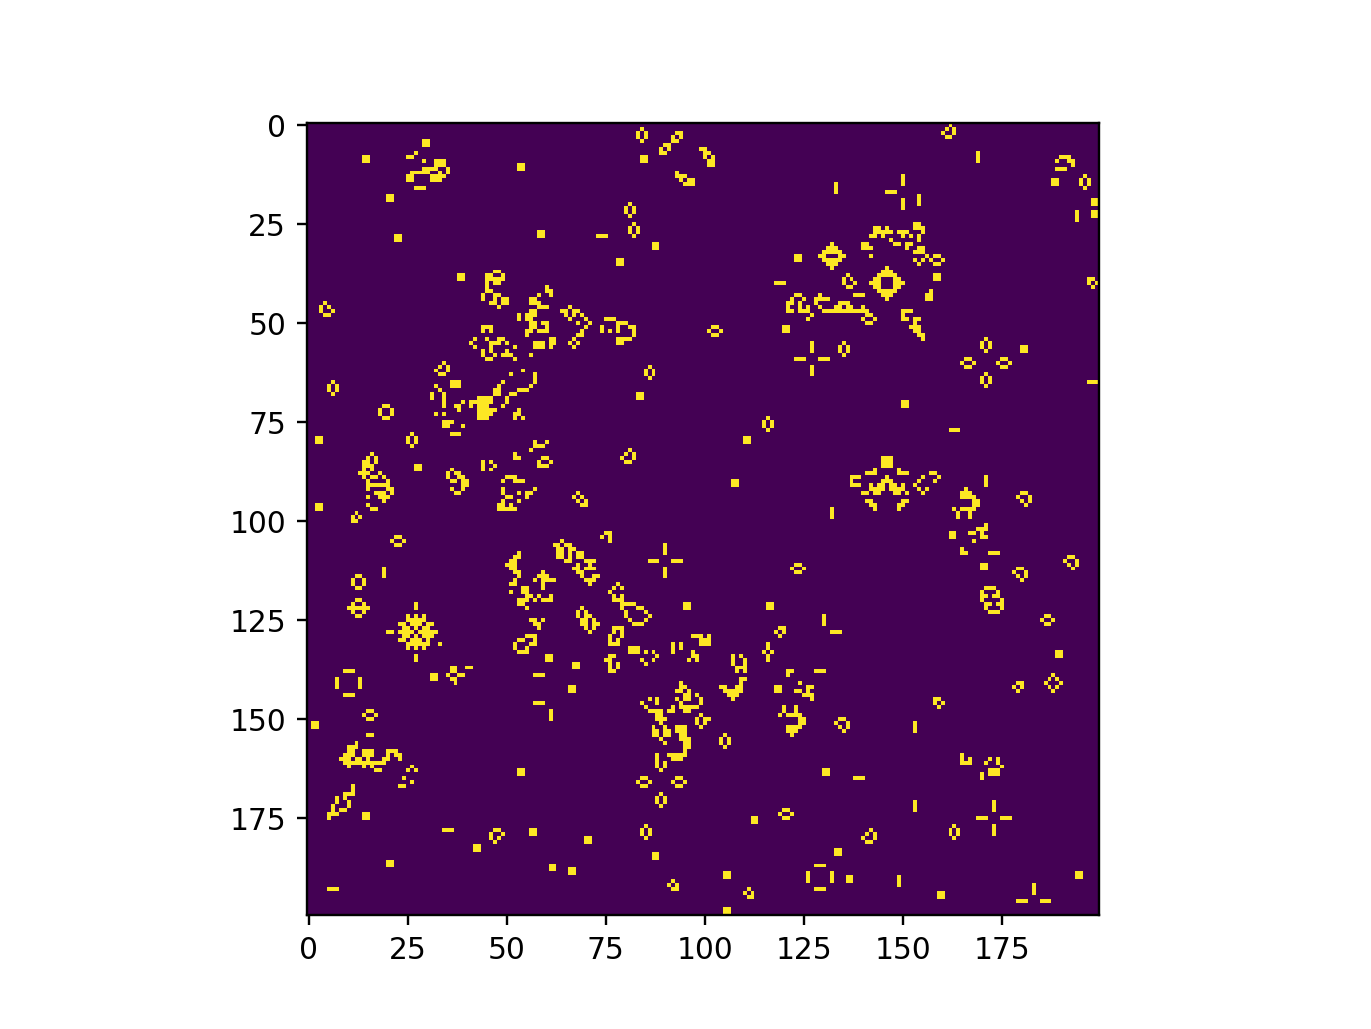

In [28]:
n = 200
cells = random_state(n, .1)

fig = plt.figure()
im = plt.imshow(cells,vmin=0,vmax=1)               # Generate the initial plot

def animate(i):
    cells[:,:] = update_cells(cells)
    im.set_data(cells)                             # Update the figure with new x array
    return im

anim = FuncAnimation(fig, animate, cache_frame_data=False)
plt.show()


What can we do to make our code run more efficiently? At a `200` by `200` grid, it is very slow to update.

Let's look at the `count_live_neighbors` function, which will run $n^2$ times for an $n$ by $n$ grid. Let's rewrite `count_live_neighbors` to take `padded_cells` in as an input.

In [30]:
def count_live_neighbors(cells,padded_cells,i,j):
    # Recall: The [i,j]th index of cells corresponds to
    # the [i+1, j+1]st index of padded_cells
    
    # We want a 3 by 3 grid centered at the [i,j]th cell of cells
    grid = padded_cells[i:i+3, j:j+3]

    # We can subtract cells[i,j] from the sum
    # to either remove a wrongly counted live neighbor
    # or do nothing if cells[i,j] is not alive
    live_neighbors = np.sum(grid) - cells[i,j]
    
    return live_neighbors

We'll then need to update the `update_cells` function to pass in `padded_cells`:

In [31]:
def update_cells(cells):
    new_cells = cells.copy()

    nrows, ncols = cells.shape
    padded_cells = np.zeros((nrows+2, ncols+2), dtype=int)
    padded_cells[1:-1, 1:-1] = cells
    for i in range(nrows):
        for j in range(ncols):
            # Get the number of live neighbors, excluding the cell itself
            live_neighbors = count_live_neighbors(cells, padded_cells, i, j)
            
            # If the is alive...
            if cells[i,j] == 1:
                # and if the cell has exactly 2 or 3 live neighbors...
                if live_neighbors == 2 or live_neighbors == 3:
                    # then the cell lives
                    new_cells[i,j] = 1
                else:
                    # otherwise the cell dies
                    new_cells[i,j] = 0
            # If the cell is not alive...
            else:
                # and if it has exactly 3 live neighbors...
                if live_neighbors == 3:
                    # then the cell becomes alive
                    new_cells[i,j] = 1
                else:
                    # otherwise the cell remains dead
                    new_cells[i,j] = 0
    return new_cells


Let's see if that helps:

<IPython.core.display.Javascript object>


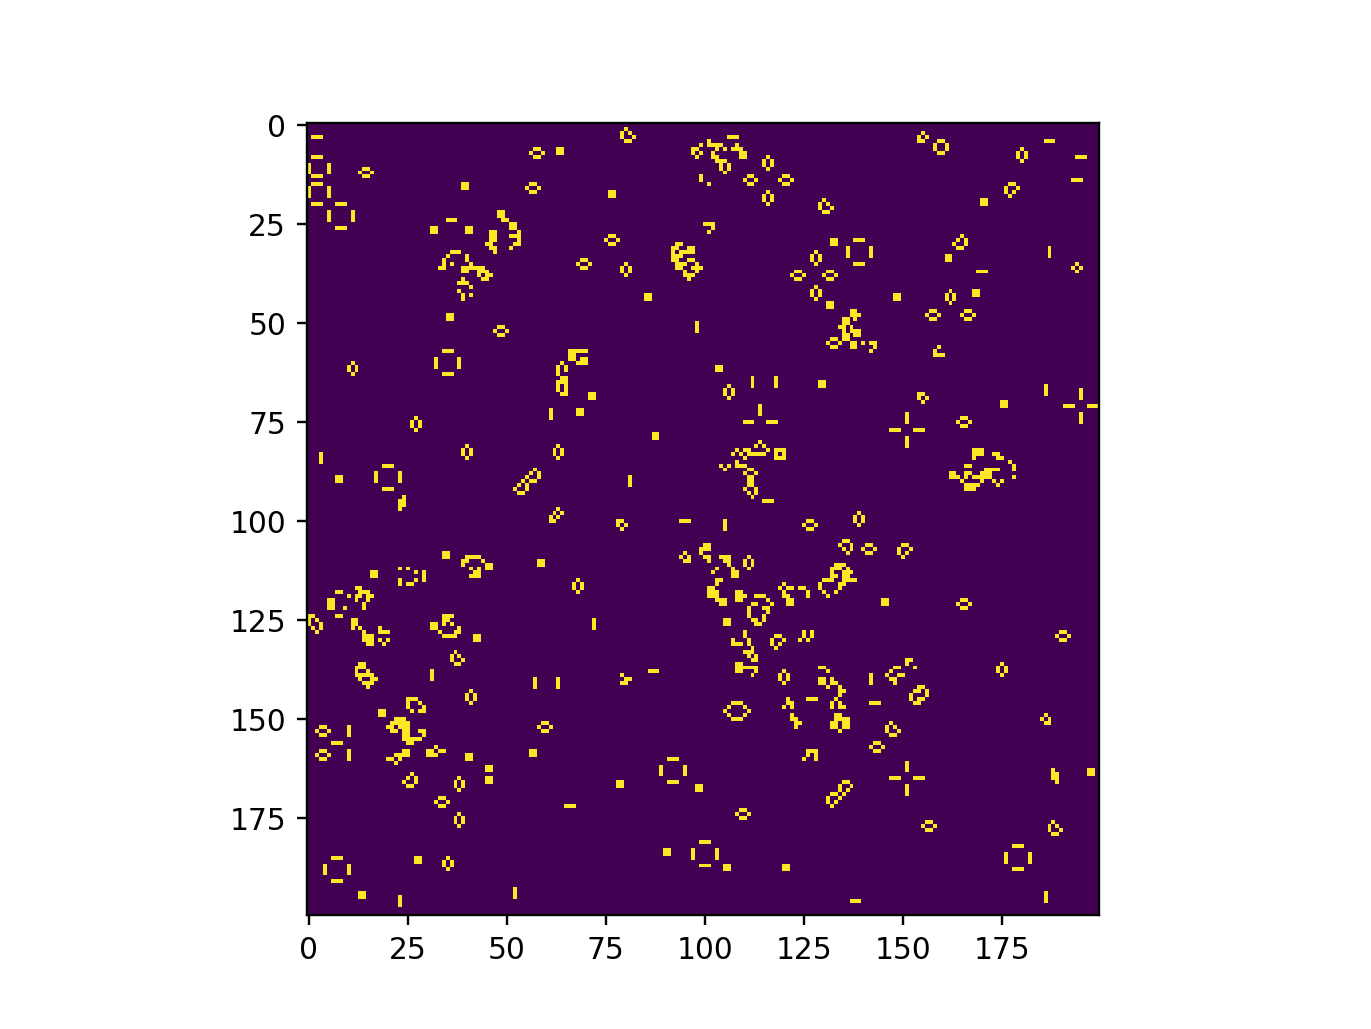

In [32]:
n = 200
cells = random_state(n, .1)

fig = plt.figure()
im = plt.imshow(cells,vmin=0,vmax=1)               # Generate the initial plot

def animate(i):
    cells[:,:] = update_cells(cells)
    im.set_data(cells)                             # Update the figure with new x array
    return im

anim = FuncAnimation(fig, animate, cache_frame_data=False)
plt.show()
